---

Name: Divani Rafitya
- [Dataset](https://colab.research.google.com/drive/1Pe_wp6UoCBH-13ORQSXiVJwPEdmy8msw?usp=sharing)

---

## Business Understanding

Dari data yang diambil dari BigQuery, dataset menunjukkan informasi tentang penggunaan kartu kredit oleh customer berdasarkan perilaku customer dalam menggunakan kartu kredit. Sebagai data scientist, saya diminta untuk menganalisis pola pembelian customer, kecenderungan pengeluaran dan pembayaran kartu kredit dengan mengelompokkan customer berdasarkan karakteristik penggunaan kartu kreditnya.

Oleh karena itu, terbentuklah objective untuk dapat mengelompokkan customer berdasarkan karakteristik penggunaan kartu kreditnya berdasarkan perilaku customer dalam menggunakan kartu kredit, dimana hal ini akan berguna untuk melihat resiko kredit tiap customer dan menentukan pendekatan strategi marketing yang sesuai dengan karakteristik masing-masing kelompok.

Dalam hal ini, saya membuat model machine learning untuk dapat mengelompokkan customer berdasarkan karakteristik penggunaan kartu kreditnya. Model machine learning ini akan dilakukan dengan metode K-Means untuk mengelompokkan customer berdasarkan behaviour/perilaku customer kedalam kelompok-kelompok yang berbeda sesuai dengan kecenderungan karakteristiknya. 

Selain itu, akan digunakan Principal Component Analysis (PCA) untuk mengurangi jumlah dimensi dengan menentukan feature yang paling relevan dan tetap mempertahankan sebagian besar informasi penting, dan Elbow Method untuk memilih jumlah cluster yang optimal dalam pengelompokan customer kartu kredit. Selain itu, untuk penentuan jumlah cluster optimal akan menggunakan Silhouette Score dan Silhouette Plot.

## Query SQL

<!-- connect data from bigquery -->
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

<!-- select project id on Google Cloud Platform -->
project_id = "gc-6-credit-card"
client = bigquery.Client(project=project_id)

<!-- query data -->
```sql
df = client.query('''
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_006_bsd.credit-card-information`
WHERE MOD(CUST_ID,2) = 0 #jika dibagi 2 sisanya 0
''').to_dataframe()
```

## Import Libraries

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

# import models
from feature_engine.outliers import Winsorizer
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

# import warnings
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
# loading dataset from .csv file to pandas dataframe
df_ori = pd.read_csv('credit_card_dataset.csv')
pd.set_option('display.max_columns',None) #display all columns

In [3]:
# duplicate original dataset
df = df_ori.copy()

In [4]:
# show first 10 rows as sample
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,0.875000,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,0.125000,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,1.000000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,1.000000,1450.0,1450.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,397.090516,227.143184,0.0,8
5,4266,2237.238086,1.000000,120.0,120.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2500.0,343.102984,712.986387,0.0,8
6,4360,2730.843802,1.000000,2900.0,2900.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2900.0,0.000000,NaN,0.0,8
7,4680,424.994385,0.375000,1200.0,1200.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,57.266292,56.720210,0.0,8
8,5884,18.885677,0.375000,57.0,57.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
9,24,0.004816,0.545455,51.7,0.0,51.7,0.0,0.250,0.000,0.250,0.0,0,3,3000.0,33.249088,0.059481,0.0,12


In [5]:
# show last 10 rows as sample
df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,1588,538.768762,0.909091,226.95,129.58,97.37,452.009130,0.545455,0.090909,0.454545,0.272727,8,9,1200.0,946.649324,211.220001,0.000000,11
4466,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.000000,11
4467,2528,427.642111,0.888889,0.00,0.00,0.00,2563.705644,0.000000,0.000000,0.000000,0.888889,62,0,1200.0,2853.967334,146.976542,0.500000,9
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.000000,9
4469,2152,1420.727073,1.000000,0.00,0.00,0.00,311.804499,0.000000,0.000000,0.000000,0.900000,9,0,1500.0,506.765033,449.179818,0.000000,10
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11
4474,3564,1977.007090,1.000000,1032.04,226.90,805.14,4335.919227,0.909091,0.090909,0.818182,0.545455,21,17,4000.0,3056.424974,910.707525,0.090909,11


In [6]:
# show dataframe summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [7]:
# check missing value in dataset
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
# check for duplications in dataset
df.duplicated().sum()

0

Berdasarkan informasi di atas, insight yang diperoleh adalah sebagai berikut:
- Dataset ini terdiri dari `18 columns` dengan total `4475 data entries`.
- Tipe data untuk setiap column sudah sesuai.
- Terdapat missing value pada dataset, yaitu pada column `CREDIT_LIMIT dan MINIMUM_PAYMENTS`
- Tidak terdapat data duplicates dalam dataset.

Dalam hal ini, handling missing value akan dilakukan pada tahap feature engineering dikarenakan kita harus mencari tahu terlebih dahulu tipe missing valuenya seperti apa untuk menentukan handling yang sesuai.

## Exploratory Data Analysis

### Pertama, saya ingin mengetahui seberapa sering customer melakukan pembayaran kartu kredit untuk memperbaharui saldo kreditnya berdasarkan 'BALANCE_FREQUENCY'.

In [9]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.BALANCE_FREQUENCY:
    balance_freq = float(i)
    if (balance_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= balance_freq < 0.8):
        lists.append('Moderate')
    elif (balance_freq < 0.5):
        lists.append('Low')

# create new column
df['BALANCE_FREQUENCY_CAT'] = lists

<Axes: xlabel='BALANCE_FREQUENCY_CAT'>

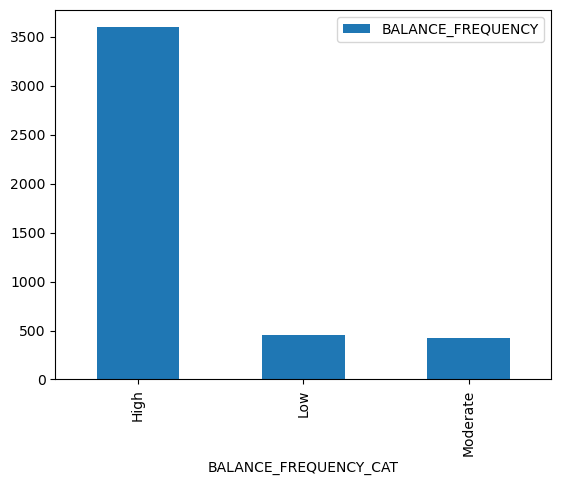

In [10]:
# data visualization
df.groupby('BALANCE_FREQUENCY_CAT')[['BALANCE_FREQUENCY']].count().plot(kind='bar')

Dari gambar diatas, insight yang diperoleh adalah frekuensi pembayaran kartu kredit oleh customer yang tinggi. Hal ini menandakan bahwa terdapat kecenderungan behaviour dimana customer secara rutin melakukan pembayaran tagihan kartu kreditnya.

### Kedua, saya ingin mengetahui seberapa sering customer melakukan pembelian dengan kartu kreditnya berdasarkan 'PAYMENT_FREQUENCY'.

In [11]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.PURCHASES_FREQUENCY:
    purchase_freq = float(i)
    if (purchase_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= purchase_freq < 0.8):
        lists.append('Moderate')
    elif (purchase_freq < 0.5):
        lists.append('Low')

# create new column
df['PURCHASES_FREQUENCY_CAT'] = lists

<Axes: xlabel='PURCHASES_FREQUENCY_CAT'>

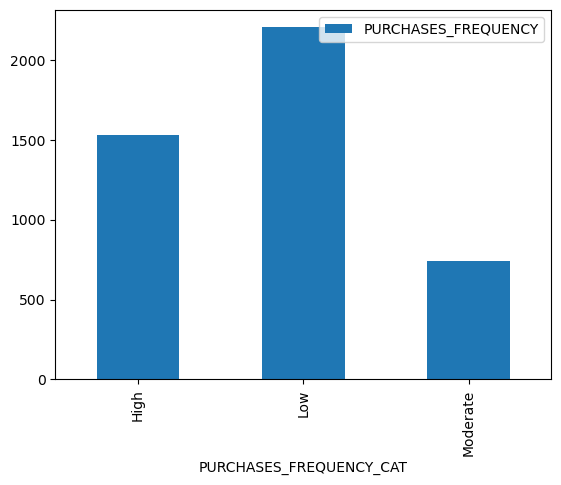

In [12]:
# data visualization
df.groupby('PURCHASES_FREQUENCY_CAT')[['PURCHASES_FREQUENCY']].count().plot(kind='bar')

Dari gambar diatas, insight yang diperoleh adalah frekuensi pembelian menggunakan kartu kredit oleh customer yang rendah. Hal ini menandakan bahwa terdapat kecenderungan behaviour dimana customer menggunakan kartu kredit dengan bijak dan tidak berlebihan, seperti hanya untuk keperluan mendesak atau sehari-hari saja dan tidak konsumtif.

### Ketiga, saya ingin mengetahui seberapa sering customer melakukan pembelian satu kali (tidak berulang) berdasarkan 'ONEOFF_PURCHASES_FREQUENCY'.

In [13]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.ONEOFF_PURCHASES_FREQUENCY:
    oneoff_freq = float(i)
    if (oneoff_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= oneoff_freq < 0.8):
        lists.append('Moderate')
    elif (oneoff_freq < 0.5):
        lists.append('Low')

# create new column
df['ONEOFF_PURCHASES_FREQUENCY_CAT'] = lists

<Axes: xlabel='ONEOFF_PURCHASES_FREQUENCY_CAT'>

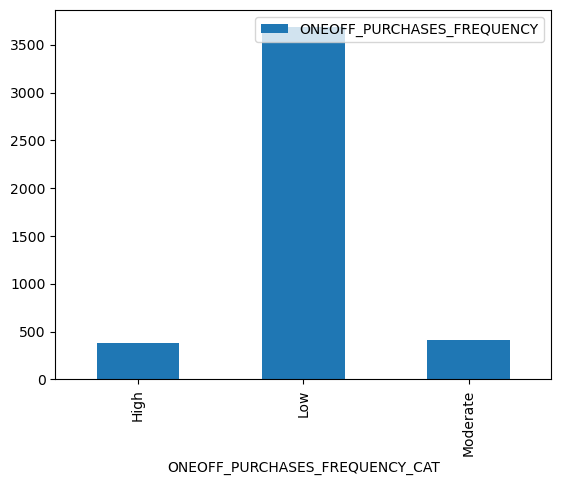

In [14]:
# data visualization
df.groupby('ONEOFF_PURCHASES_FREQUENCY_CAT')[['ONEOFF_PURCHASES_FREQUENCY']].count().plot(kind='bar')

Dari gambar diatas, insight yang diperoleh adalah frekuensi pembelian dengan satu kali transaksi menggunakan kartu kredit oleh customer yang rendah. Hal ini menandakan bahwa terdapat kecenderungan perilaku dimana customer jarang melakukan pengeluaran yang besar sekaligus dalam satu waktu. Dari insight ini ada dua kemungkinan yang muncul, yaitu kemungkinan customer menggunakan kartu kredit dengan bijak dan tidak berlebihan atau customer memilih untuk melakukan pembayaran dengan cicilan.

### Keempat, saya ingin mengetahui seberapa sering customer melakukan pembelian secara mencicil berdasarkan 'PURCHASES_INSTALLMENTS_FREQUENCY'.

In [15]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.PURCHASES_INSTALLMENTS_FREQUENCY:
    installment_freq = float(i)
    if (installment_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= installment_freq < 0.8):
        lists.append('Moderate')
    elif (installment_freq < 0.5):
        lists.append('Low')

# create new column
df['PURCHASES_INSTALLMENTS_FREQUENCY_CAT'] = lists

<Axes: xlabel='PURCHASES_INSTALLMENTS_FREQUENCY_CAT'>

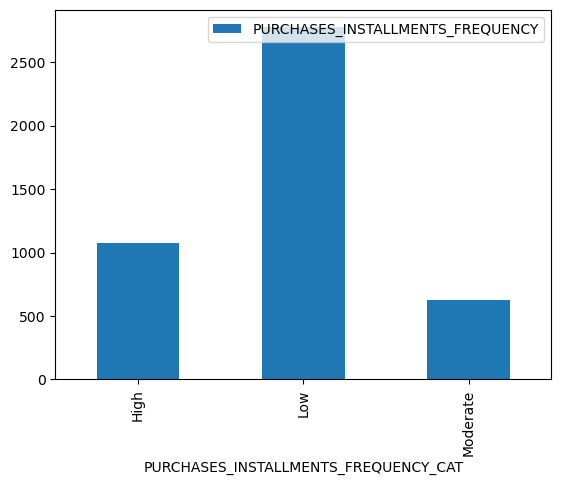

In [16]:
# data visualization
df.groupby('PURCHASES_INSTALLMENTS_FREQUENCY_CAT')[['PURCHASES_INSTALLMENTS_FREQUENCY']].count().plot(kind='bar')

Dari gambar diatas, ternyata insight yang diperoleh adalah frekuensi pembelian dengan cicilan menggunakan kartu kredit oleh customer juga rendah. Artinya, kecenderungan behaviour customer kartu kredit adalah dapat menggunakan kartu kredit dengan bijak dan tidak berlebihan, terlebih untuk keperluan yang bersifat konsumtif. Hal ini mengindikasikan bahwa customer memiliki resiko kredit yang rendah dan sehat.

### Kelima, saya ingin mengetahui seberapa sering customer melakukan penarikan tunai berdasarkan 'CASH_ADVANCE_FREQUENCY'.

In [17]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.CASH_ADVANCE_FREQUENCY:
    oneoff_freq = float(i)
    if (oneoff_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= oneoff_freq < 0.8):
        lists.append('Moderate')
    elif (oneoff_freq < 0.5):
        lists.append('Low')

# create new column
df['CASH_ADVANCE_FREQUENCY_CAT'] = lists

<Axes: xlabel='CASH_ADVANCE_FREQUENCY_CAT'>

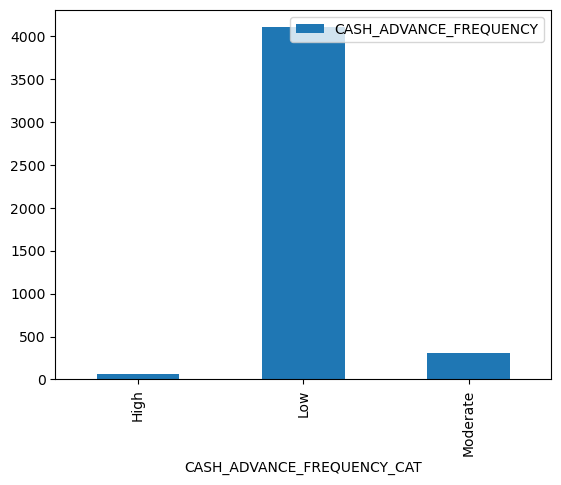

In [18]:
# data visualization
df.groupby('CASH_ADVANCE_FREQUENCY_CAT')[['CASH_ADVANCE_FREQUENCY']].count().plot(kind='bar')

Dari gambar diatas, insight yang diperoleh adalah frekuensi penarikan tunai menggunakan kartu kredit oleh customer yang rendah. Hal ini menandakan bahwa mayoritas customer tidak memiliki tanda-tanda masalah keuangan dikarenakan untuk melakukan penarikan tunai dengan kartu kredit biasanya dikenakan biaya tambahan, dengan kemungkinan besar customer memilih untuk melakukan penarikan tunai dengan kartu debit atau melakukan pembayaran dengan cashless payment.

### Keenam, saya ingin melihat distribusi dari persentase customer yang melakukan pembayaran penuh berdasarkan 'PRC_FULL_PAYMENT'.

<Axes: xlabel='PRC_FULL_PAYMENT', ylabel='Count'>

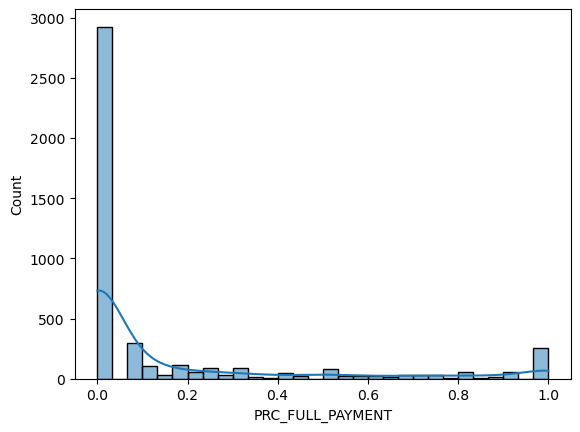

In [19]:
# data visualization
sns.histplot(df['PRC_FULL_PAYMENT'],kde=True,bins=30)

Dari gambar diatas, insight yang diperoleh adalah perbedaan hasil persentase pembayaran penuh (1) dan tidak penuh (0) sangat signifikan. Hal ini menunjukkan bahwa terdapat kecenderungan perilaku dimana customer hanya membayar sebagian kecil dari total tagihan kartu kreditnya setiap bulan saja sesuai minimum payment, dengan hanya sekitar 20% saja yang melakukan pembayaran penuh.

### Ketujuh, saya ingin melihat jangka waktu yang dibutuhkan customer untuk membayar tagihan cicilan kartu kredit  berdasarkan 'TENURE'.

<Axes: xlabel='TENURE', ylabel='count'>

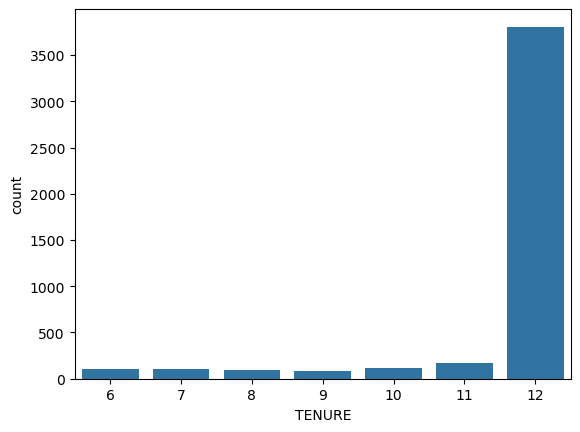

In [20]:
# data visualization
sns.barplot(df['TENURE'].value_counts())

Dari gambar diatas, insight yang diperoleh adalah mayoritas customer kartu kredit memilih waktu tenor yang panjang, yaitu 12 bulan. Hal ini menunjukkan bahwa terdapat kecenderungan perilaku dimana customer memilih untuk membayar tagihan dengan cicilan yang lebih kecil setiap bulan secara teratur, meskipun bunga yang dibayarkan akan lebih besar dalam jangka panjang. Hal ini mengindikasikan bahwa pemilihan tenor cicilan ini kemungkinan dipilih untuk pembelian yang bersifat konsumtif, bukan untuk sehari-hari, dan hal ini juga menandakan customer dapat mengelola keuangan bulanan dengan baik sesuai dengan anggaran bulanan masing-masing customer.

## Feature Engineering

Sebelum melakukan feature engineering, kita akan drop column 'CUST_ID' terlebih dahulu karena setiap nilainya unik dan tidak memberikan informasi yang berguna secara signifikan dalam analisis data.
Selain itu, saya juga akan menghapus column yang telah dibuat pada EDA.

In [21]:
# drop column
df.drop(['CUST_ID'],axis= 1,inplace=True)
df.drop(['BALANCE_FREQUENCY_CAT','PURCHASES_FREQUENCY_CAT','ONEOFF_PURCHASES_FREQUENCY_CAT','PURCHASES_INSTALLMENTS_FREQUENCY_CAT','CASH_ADVANCE_FREQUENCY_CAT'],axis= 1,inplace=True)

# check dataframe
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,16.581535,0.125,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,943.584041,0.875,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8
2,1.979916,0.125,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
3,461.455720,1.000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8
4,1053.594730,1.000,1450.0,1450.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,397.090516,227.143184,0.0,8


### Handling Missing Value

In [22]:
# check missing value
df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Dalam hal ini, kemungkinan terjadi missing valuenya didefinisikan sebagai `Missing at Random (MAR)` karena kemungkinan besar customer merasa tidak nyaman memberikan informasi MINIMUM_PAYMENTS nya dan terdapat kemungkinan customer tidak mengetahui berapa MINIMUM_PAYMENTS dan CREDIT_LIMIT kartu kreditnya sehingga baris tersebut dikosongkan oleh customer.

Dikarenakan missing value pada dataset adalah 159 data entries, maka akan dilakukan handling missing value dengan drop data entriesnya. Hal ini dikarenakan nilai missing value < 5% dari data sehingga data yang hilang tidak banyak dan tidak perlu imputasi dengan nilai mean.

In [23]:
# handling missing value with dropna
df.dropna(inplace=True)

# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4316 entries, 1 to 4474
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           4316 non-null   float64
 1   BALANCE_FREQUENCY                 4316 non-null   float64
 2   PURCHASES                         4316 non-null   float64
 3   ONEOFF_PURCHASES                  4316 non-null   float64
 4   INSTALLMENTS_PURCHASES            4316 non-null   float64
 5   CASH_ADVANCE                      4316 non-null   float64
 6   PURCHASES_FREQUENCY               4316 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        4316 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  4316 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            4316 non-null   float64
 10  CASH_ADVANCE_TRX                  4316 non-null   int64  
 11  PURCHASES_TRX                     4316 non-null   int64  
 12  CREDIT_LIMI

### Handling Outlier

Dikarenakan handling outlier hanya dilakukan pada column numerical saja, maka jika ada column categorical akan di drop. Dalam hal ini, semua column nya sudah numerical.

Berikut adalah pengecekan skewness dan visualisasi box plot pada masing-masing column numerical sebelum melakukan handling outlier.

In [24]:
# check skewness before handling
skew_result = []
for i in df.columns:
    skewness = df[i].skew()
    skew_result.append((i, skewness))

for i, skewness in skew_result:
    print(f"Skewness {i}: {skewness}")

Skewness BALANCE: 2.440901091038025
Skewness BALANCE_FREQUENCY: -2.083168233926595
Skewness PURCHASES: 8.902272454100581
Skewness ONEOFF_PURCHASES: 10.045515316290516
Skewness INSTALLMENTS_PURCHASES: 8.030304885938177
Skewness CASH_ADVANCE: 4.713174552567423
Skewness PURCHASES_FREQUENCY: 0.035641946018049195
Skewness ONEOFF_PURCHASES_FREQUENCY: 1.49450472491376
Skewness PURCHASES_INSTALLMENTS_FREQUENCY: 0.4865766900569389
Skewness CASH_ADVANCE_FREQUENCY: 1.7888346981313274
Skewness CASH_ADVANCE_TRX: 4.722877319817404
Skewness PURCHASES_TRX: 4.429897311633816
Skewness CREDIT_LIMIT: 1.525378783156858
Skewness PAYMENTS: 5.987444897467956
Skewness MINIMUM_PAYMENTS: 12.356757627194938
Skewness PRC_FULL_PAYMENT: 1.8543999106579778
Skewness TENURE: -2.9969780616789303


{'whiskers': [<matplotlib.lines.Line2D at 0x12d54d350>,
 'caps': [<matplotlib.lines.Line2D at 0x12d54ec10>,
 'boxes': [<matplotlib.lines.Line2D at 0x12d54c790>,
 'medians': [<matplotlib.lines.Line2D at 0x12d558190>,
 'fliers': [<matplotlib.lines.Line2D at 0x12d558bd0>,
 'means': []}

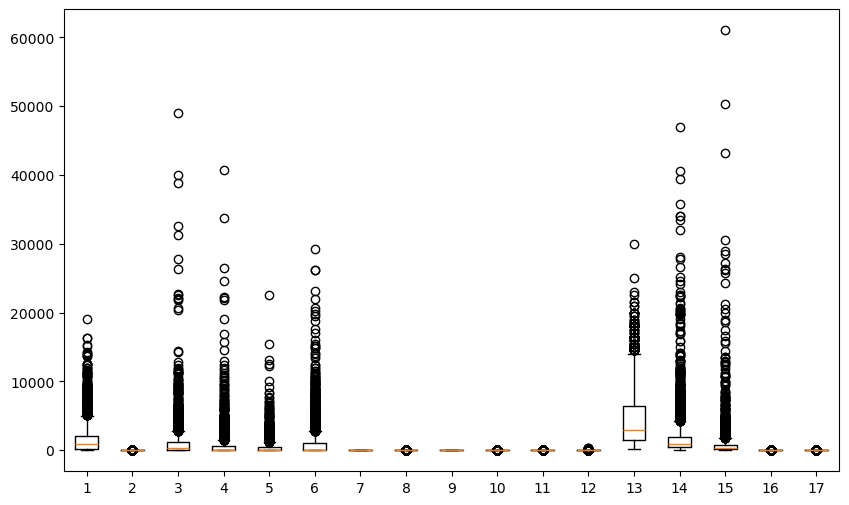

In [25]:
# show boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df.values)

Selanjutnya, kita akan mengkategorikan column berdasarkan distribusi datanya terlebih dahulu menggunakan looping `for in` untuk mempermudah pengecekannya.

In [26]:
# create list to contain default value
normal = []
moderate = []
extreme = []

# create looping with for in
for i in df.columns:
    skew = df[i].skew() #to input i in list
    if -0.5 < skew and skew < 0.5:
        normal.append(i)
    elif -1 <= skew <= -0.5 or 0.5 <= skew <= 1:
        moderate.append(i)
    elif skew < 1 or skew > 1:
        extreme.append(i)

print(f"Normal distribution: {normal}")
print(f"Moderate distribution: {moderate}")
print(f"Extreme distribution: {extreme}")

Normal distribution: ['PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']
Moderate distribution: []
Extreme distribution: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


Selanjutnya, handling outlier akan dilakukan dengan metode capping dengan mengubah nilai outlier yang dapat mempengaruhi analisis menjadi nilai yang masuk akal (tidak menghapus/mengurangi data outlier).

In [27]:
# exclude column 'TENURE' because it has low variation
extreme_cap = [extreme_cap for extreme_cap in extreme if extreme_cap not in ['TENURE']]
extreme_cap

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'ONEOFF_PURCHASES_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT']

In [28]:
# capping normal distribution outliers
winsoriser_normal = Winsorizer(capping_method='gaussian',
                               tail='both',
                               fold=3,
                               variables=normal)

df = winsoriser_normal.fit_transform(df)

# capping outliers using winsoriser
winsoriser_extreme = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3, #extreme
                             variables=extreme_cap)

df = winsoriser_extreme.fit_transform(df)

Berikut adalah pengecekan skewness dan visualisasi box plot pada masing-masing column numerical setelah melakukan handling outlier.

In [29]:
# check skewness after handling
skew_result = []
for i in df.columns:
    skewness = df[i].skew()
    skew_result.append((i, skewness))

for i, skewness in skew_result:
    print(f"Skewness {i}: {skewness}")

Skewness BALANCE: 1.7554243778697436
Skewness BALANCE_FREQUENCY: -1.4325537689023737
Skewness PURCHASES: 1.7975552825882841
Skewness ONEOFF_PURCHASES: 1.7230166985073903
Skewness INSTALLMENTS_PURCHASES: 1.7693360760377685
Skewness CASH_ADVANCE: 1.7110692188675976
Skewness PURCHASES_FREQUENCY: 0.035641946018049195
Skewness ONEOFF_PURCHASES_FREQUENCY: 1.49450472491376
Skewness PURCHASES_INSTALLMENTS_FREQUENCY: 0.4865766900569389
Skewness CASH_ADVANCE_FREQUENCY: 1.7737965685778758
Skewness CASH_ADVANCE_TRX: 1.765607171086007
Skewness PURCHASES_TRX: 1.7429074232734807
Skewness CREDIT_LIMIT: 1.4681919083660107
Skewness PAYMENTS: 1.7481193392444618
Skewness MINIMUM_PAYMENTS: 1.7803857801292196
Skewness PRC_FULL_PAYMENT: 1.5248264733069976
Skewness TENURE: -2.9969780616789303


{'whiskers': [<matplotlib.lines.Line2D at 0x12d714e90>,
 'caps': [<matplotlib.lines.Line2D at 0x12d716250>,
 'boxes': [<matplotlib.lines.Line2D at 0x12d7146d0>,
 'medians': [<matplotlib.lines.Line2D at 0x12d717350>,
 'fliers': [<matplotlib.lines.Line2D at 0x12d717c10>,
 'means': []}

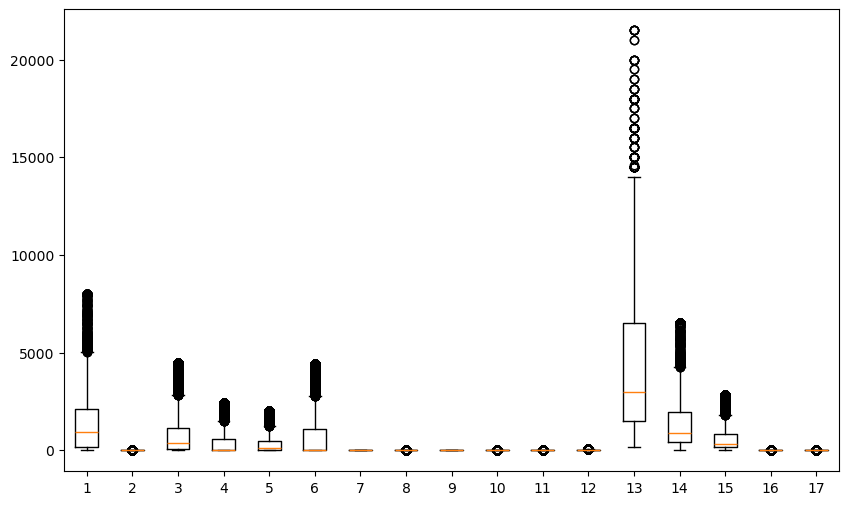

In [30]:
# show boxplot after capping
plt.figure(figsize=(10, 6))
plt.boxplot(df.values)

### Correlation for Feature Selection

Selanjutnya adalah melakukan pengecekan korelasi dengan memeriksa apakah ada multicolinarity atau tidak pada korelasinya menggunakan Variance Inflation Factor (VIF) dan library phik. Jika hasil perhitungan multicolinarity sangat tinggi atau hasil korelasi kuat, maka column akan di drop. Hal ini dikarenakan jika korelasi antara variabel independen tinggi maka akan menyebabkan koefisien regresi menjadi tidak stabil dan dapat berubah secara signifikan ketika sampel data berubah.
Dalam hal ini, saya menentukan multicolinarity tinggi adalah diatas 20 dan korelasi kuat adalah diatas 0.9.

In [31]:
# calculate VIF untuk setiap feature
vif = pd.DataFrame()
vif['variable'] = df.columns
vif['vif'] = [variance_inflation_factor(df, i) for i in range(df.shape[1])] #1 adalah jumlah column
vif

,variable,vif
0,BALANCE,7.977662
1,BALANCE_FREQUENCY,49.166998
2,PURCHASES,36.842610
3,ONEOFF_PURCHASES,20.174754
4,INSTALLMENTS_PURCHASES,11.521851
5,CASH_ADVANCE,4.480478
6,PURCHASES_FREQUENCY,27.483630
7,ONEOFF_PURCHASES_FREQUENCY,8.937775
8,PURCHASES_INSTALLMENTS_FREQUENCY,21.845081
9,CASH_ADVANCE_FREQUENCY,8.866586


In [32]:
# calculate correlation matrix with phik
phik_overview = df.phik_matrix()
phik_overview

interval columns not set, guessing: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.337300,0.223396,0.125677,0.214834,0.545795,0.210336,0.129508,0.189997,0.477298,0.500372,0.223600,0.635461,0.478548,0.854834,0.505278,0.037968
BALANCE_FREQUENCY,0.337300,1.000000,0.132861,0.098208,0.127273,0.096235,0.323884,0.168236,0.247651,0.161288,0.142399,0.200917,0.110041,0.109922,0.306123,0.252123,0.572037
PURCHASES,0.223396,0.132861,1.000000,0.837629,0.750080,0.209847,0.613893,0.643996,0.491288,0.236235,0.244256,0.762816,0.416092,0.656375,0.162168,0.242844,0.085272
ONEOFF_PURCHASES,0.125677,0.098208,0.837629,1.000000,0.344542,0.126990,0.463919,0.751372,0.198407,0.133349,0.145230,0.632724,0.370179,0.528870,0.101937,0.159968,0.057973
INSTALLMENTS_PURCHASES,0.214834,0.127273,0.750080,0.344542,1.000000,0.247028,0.660695,0.284578,0.718566,0.278445,0.287912,0.709944,0.293381,0.465295,0.237358,0.298808,0.088552
CASH_ADVANCE,0.545795,0.096235,0.209847,0.126990,0.247028,1.000000,0.375322,0.145614,0.312606,0.691942,0.729000,0.295208,0.398783,0.451113,0.473027,0.293003,0.103384
PURCHASES_FREQUENCY,0.210336,0.323884,0.613893,0.463919,0.660695,0.375322,1.000000,0.815373,0.884504,0.396694,0.413376,0.763706,0.165948,0.234692,0.220582,0.332459,0.166544
ONEOFF_PURCHASES_FREQUENCY,0.129508,0.168236,0.643996,0.751372,0.284578,0.145614,0.815373,1.000000,0.182739,0.150407,0.161860,0.631085,0.343913,0.368839,0.083027,0.206413,0.120632
PURCHASES_INSTALLMENTS_FREQUENCY,0.189997,0.247651,0.491288,0.198407,0.718566,0.312606,0.884504,0.182739,1.000000,0.340091,0.352584,0.675853,0.113643,0.163876,0.211080,0.302749,0.215746
CASH_ADVANCE_FREQUENCY,0.477298,0.161288,0.236235,0.133349,0.278445,0.691942,0.396694,0.150407,0.340091,1.000000,0.852861,0.310914,0.169128,0.241478,0.432398,0.293859,0.186448


Berdasarkan hasil VIF, column yang di drop adalah 'BALANCE_FREQUENCY', 'TENURE', 'PURCHASES', 'PURCHASES_FREQUENCY', dan 'PURCHASES_INSTALLMENTS_FREQUENCY', sementara nilai pada column 'PURCHASES_INSTALLMENTS_FREQUENCY' dan 'ONEOFF_PURCHASES' masih dapat ditoleransi.
Dari hasil perhitungan phik, tidak ada column yang di drop karena semua hasil korelasi dibawah 0.9.

Dengan pertimbangan hasil VIF dan phik, kita akan mendrop 4 column, yaitu 'BALANCE_FREQUENCY', 'TENURE', 'PURCHASES', dan 'PURCHASES_FREQUENCY'.

In [33]:
# drop column
df.drop(['BALANCE_FREQUENCY','TENURE','PURCHASES','PURCHASES_FREQUENCY'],axis= 1,inplace=True)

In [34]:
# choose features
features = df.columns.tolist()
features

['BALANCE',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT']

### Feature Scaling

Tujuan dari dilakukannya feature scalling adalah untuk menyamakan value agar semua column dianggap sama pentingnya oleh model mission learning.
Dalam konteks clustering, metode yang cocok dan lebih umum digunakan adalah `StandardScaler`. Hal ini dikarenakan syarat K-means yang harus terpenuhi, yaitu distribusi datanya harus normal (data sudah distandardisasi) untuk menghindari pengaruh dari skala yang berbeda-beda antar feature.

In [35]:
# scaling with standardscaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

### Dimensionality Reduction using PCA

Principal Component Analysis (PCA) adalah teknik dalam analisis data yang digunakan untuk mengurangi jumlah variabel (feature atau dimensi) yang ada dalam dataset dengan tetap mempertahankan sebagian besar informasi yang terkandung dalam data tersebut (compress data). Tujuan dari penggunaan PCA adalah untuk mengurangi masalah `curse of dimensionality`, dimana jumlah feature yang tinggi/banyak akan membuat model menjadi lebih kompleks dan meningkatkan risiko overfitting.
Hal ini dilakukan dengan cara mengurangi dimensi data setelah clustering agar dapat melihat visualisasi yang lebih baik untuk melihat pola diantara masing-masing kelompok dan membantu menentukan feature yang paling relevan setelah reduce dimensionality dengan tetap mempertahankan informasi penting.

In [36]:
# dimensionality reduction using PCA
pca = PCA()
pca.fit(df_scaled)

PCA()

Selanjutnya adalah melihat Cumulative Explained Variance Ratio, dimana hal ini sangat penting untuk membantu menentukan jumlah komponen utama untuk mempertahankan sebagian besar informasi dari data asli.
Dalam perhitungannya, rentang yang dipertimbangkan untuk jumlah komponen utama dalam PCA adalah jumlah feature yang yang telah ditentukan sebelumnya.
Dalam kasus ini, jumlah feature nya adalah 13, dan +1 digunakan untuk kepentingan visualisi yang lebih jelas.

Text(0, 0.5, 'Explained Variance Ratio - Cummulative')

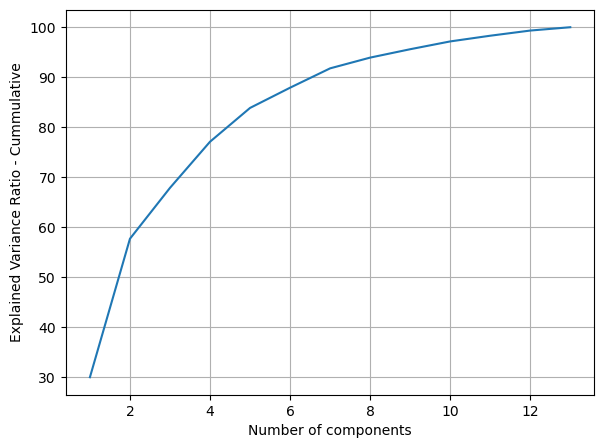

In [37]:
# ploting Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

Untuk hasil yang lebih akurat, kita akan melakukan reduksi dimensi data dengan memilih jumlah komponen yang dapat menjelaskan 90% dari total data.

In [38]:
# check the number of features if we want to retain 90% of the information
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.90) + 1 #+1 karena index dimulai dari 0
num_features

7

Setelah mengetahui number of components yang akan digunakan, kita akan melakukan reduksi dimensi berdasarkan hasil yang telah didapat sebelumnya.

In [39]:
# train the model with 7 feature
pca = PCA(n_components=7)
pca.fit(df_scaled)

df_scaled_pca = pca.transform(df_scaled)

## Model Definition

Dalam hal ini, pengelompokkan customer kartu kredit akan menggunakan metode K-Means untuk mengelompokkan data numerical berdasarkan kecenderungan karakteristiknya menjadi kelompok-kelompok yang berbeda.

Berikut adalah visualisasi data sebelum melakukan clustering.

<Axes: >

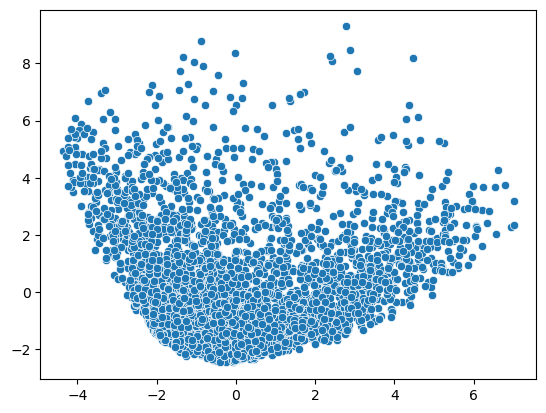

In [40]:
# check plot before clustering
sns.scatterplot(x=df_scaled_pca[:,0], y=df_scaled_pca[:,1])

### Elbow Method

Untuk memilih jumlah cluster yang optimal dalam PCA, kita dapat menggunakan teknik Elbow Method untuk memplot nilai dari Cumulative Explained Variance Ratio terhadap jumlah cluster dan mencari titik peningkatan jumlah cluster tidak memberikan peningkatan secara signifikan (tidak efisien). Hal ini dapat dilihat dari bentuknya yang menyerupai siku (elbow) pada grafik yang menandakan adanya perubahan dari vertikal jadi horizontal secara tiba-tiba.

Tidak ada parameter tertentu dalam menentukan jumlah maksimal cluster untuk visualisasi Elbow Method, namun, idealnya adalah 7-10 dengan pertimbangan jika terlalu banyak akan kesulitan untuk mengelompokkan karakteristiknya.

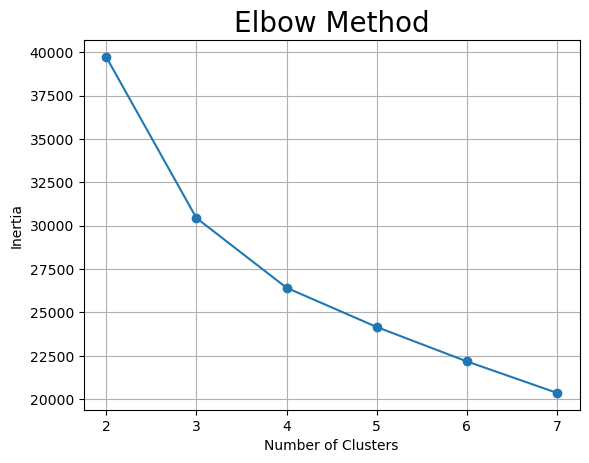

In [41]:
# find the optimal number of clusters using Elbow Method
inertia = []
random_state = 10
max_cluster = 7
for i in range(2, max_cluster+1):
    kmeans = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    kmeans.fit(df_scaled_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, max_cluster+1),inertia,marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Jumlah cluster yang tepat akan membuat ciri khas masing-masing cluster menjadi jelas dan berbeda satu sama lain. Namun, pemilihan jumlah cluster bersifat subjective sehingga kita harus melihat visualisasi dari elbow methodnya. 
Dari plot diatas, maksimal siku nya (perubahan dari vertikal jadi horizontal secara tiba-tiba) terjadi pada cluster 3 atau 4.

### Silhoutte Score and Plot

Untuk menentukan jumlah cluster yang optimal, kita akan menggunakan dua metode yang berbeda, yaitu Silhouette Score dan Silhouette Plot. Hal ini bertujuan untuk melihat perspektif yang berbeda dan membandingkan mana yang paling baik untuk menentukan jumlah cluster yang optimal.

In [42]:
# function to create silhouette plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.30595556093024223
For n_clusters = 3 The average silhouette_score is : 0.31949515865601874
For n_clusters = 4 The average silhouette_score is : 0.23230365013532012
For n_clusters = 5 The average silhouette_score is : 0.23693212470536584
For n_clusters = 6 The average silhouette_score is : 0.2290063534489528


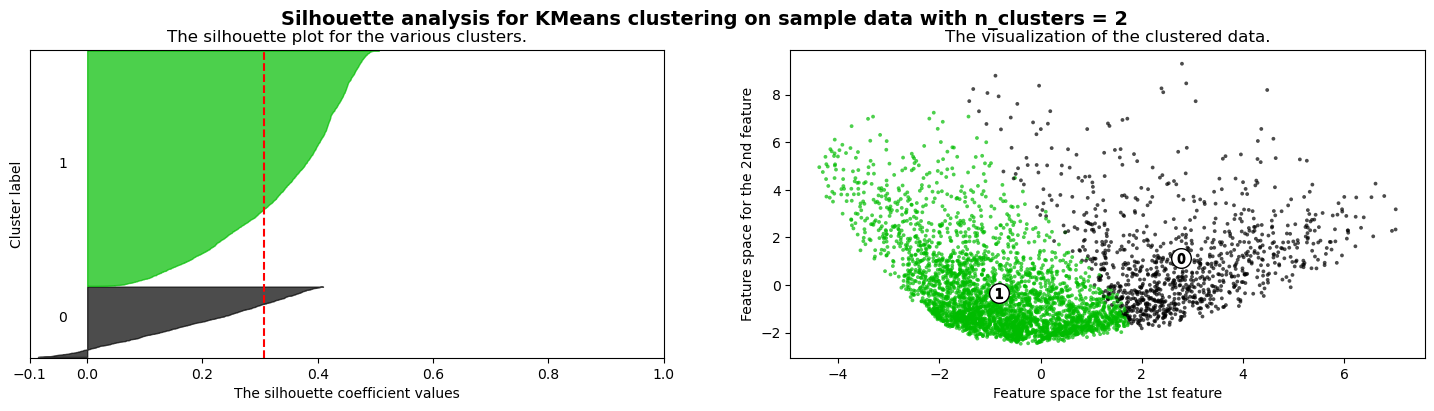

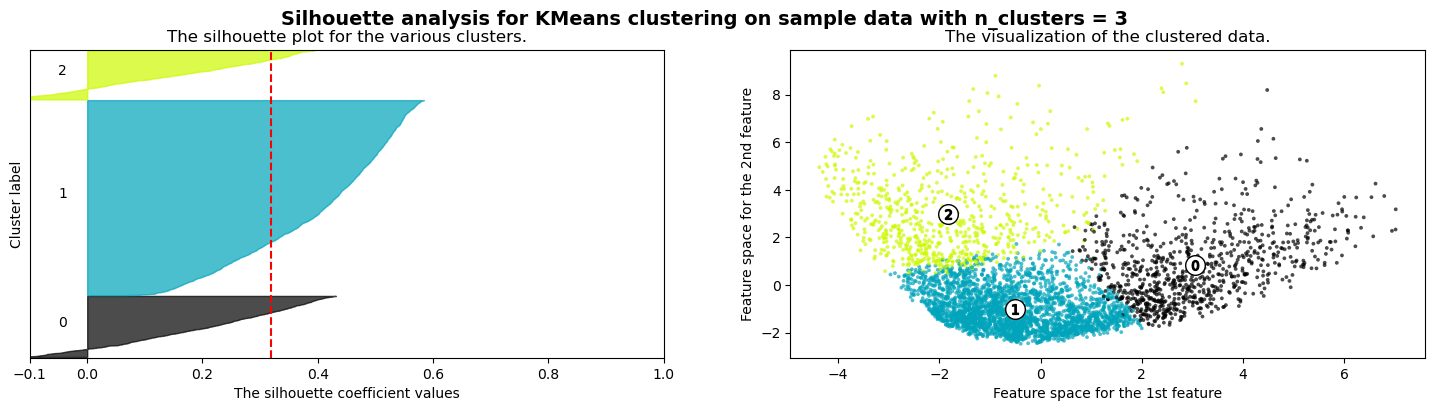

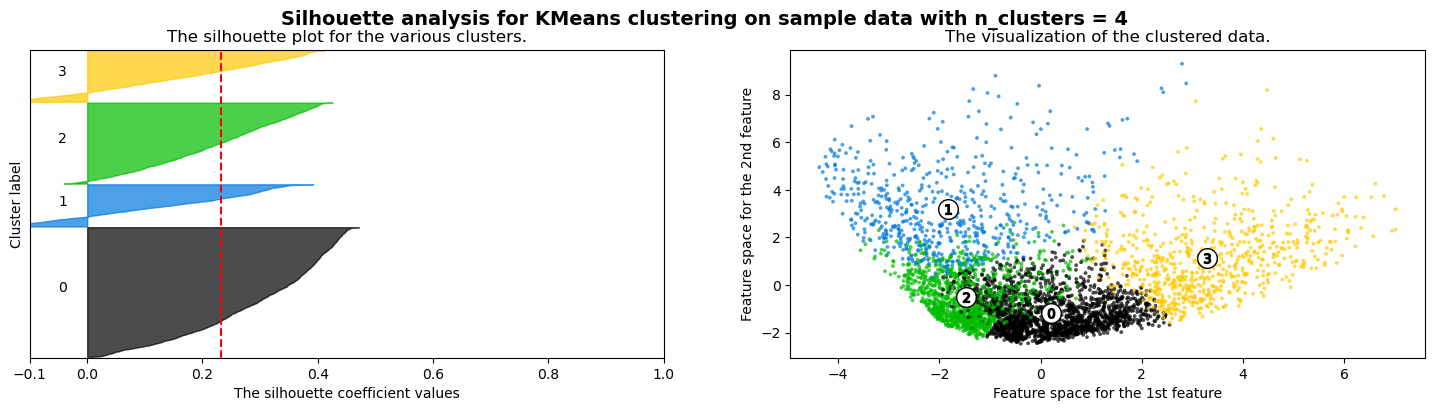

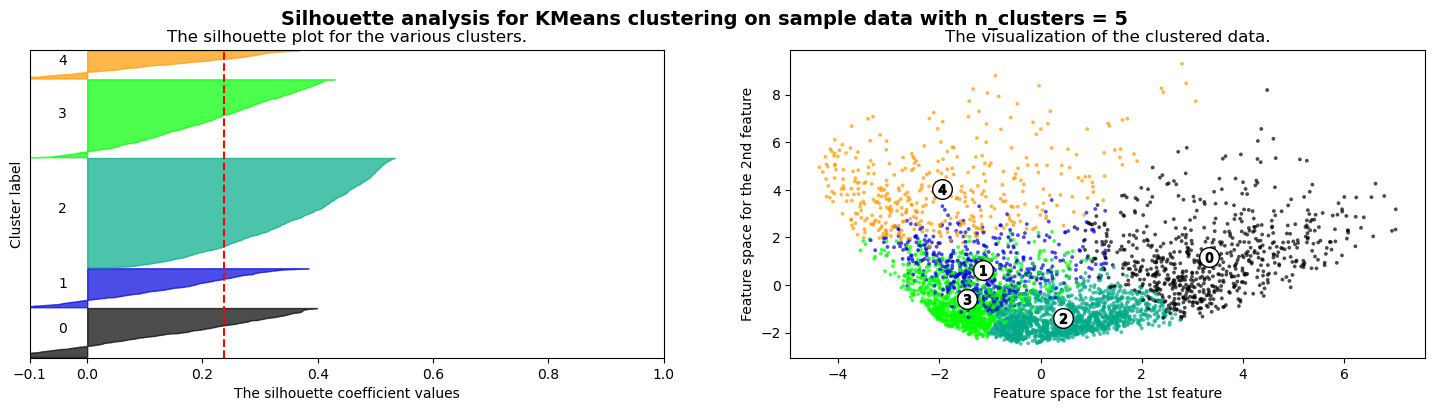

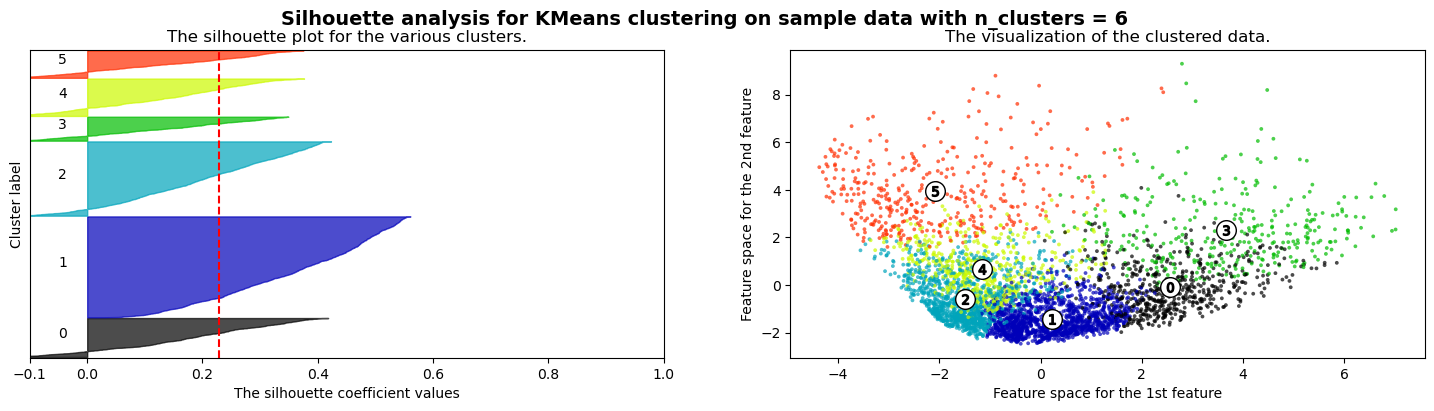

In [43]:
# display Silhouette Score and plot Silhouette Plot
plot_silhouette(range(2, max_cluster), df_scaled_pca, random_state)

Karena berdasarkan visualisasi sebelumnya elbow yang optimal adalah antara 3 atau 4, maka kita fokus membandingkan hasil silhouette plot dan score pada clustering 3 dan 4 saja.
Dari hasil silhouette plot dan silhouette score, berikut adalah insightnya:
- Hasil silhouette score pada jumlah cluster 3 memiliki hasil yang lebih besar dibandingkan jumlah cluster 4.
- Hasil silhouette plot pada jumlah cluster 4 memilihi bentuk distribusi yang lebih simetris.

Hasil analisis berdasarkan insight, `jumlah cluster yang optimal adalah 4`. Meskipun nilai silhouette score lebih rendah, namun distribusi datanya terlihat lebih merata dan menyerupai distribusi normal, baik dari segi bentuk maupun panjangnya. Hal ini mengindikasikan bahwa pengelompokan antar cluster yang cukup seimbang tanpa adanya dominasi dari salah satu cluster.

## Model Training

Selanjutnya adalah training model dengan K-Means menggunakan jumlah cluster yang optimal, yaitu 4.

In [44]:
# train with optimal number of clusters
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)

In [45]:
# predict with K-Means
pred = kmeans.fit_predict(df_scaled_pca)
pred

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [46]:
# insert clustering result into dataset
df['CLUSTER'] = pred

# show dataframe with new column
df

,BALANCE,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,CLUSTER
1,943.584041,103.00,0.00,0.000000,0.125000,0.000000,0.000000,0,1,1000.0,215.325023,410.484825,0.000000,0
3,461.455720,585.00,0.00,0.000000,0.125000,0.000000,0.000000,0,1,1000.0,258.032630,151.696433,0.000000,0
4,1053.594730,1450.00,0.00,0.000000,0.125000,0.000000,0.000000,0,1,1500.0,397.090516,227.143184,0.000000,0
5,2237.238086,120.00,0.00,0.000000,0.125000,0.000000,0.000000,0,1,2500.0,343.102984,712.986387,0.000000,0
7,424.994385,1200.00,0.00,0.000000,0.125000,0.000000,0.000000,0,1,1200.0,57.266292,56.720210,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,1079.008102,0.00,0.00,1259.571764,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,0
4471,809.582978,0.00,0.00,3819.672466,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,3
4472,3386.490883,427.22,133.76,2008.153534,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,3
4473,4840.545574,1595.93,0.00,4359.325750,0.454545,0.000000,0.545455,16,25,6000.0,905.844846,2376.919568,0.090909,3


Berikut adalah visualisasi data setelah dilakukan clustering.

<Axes: >

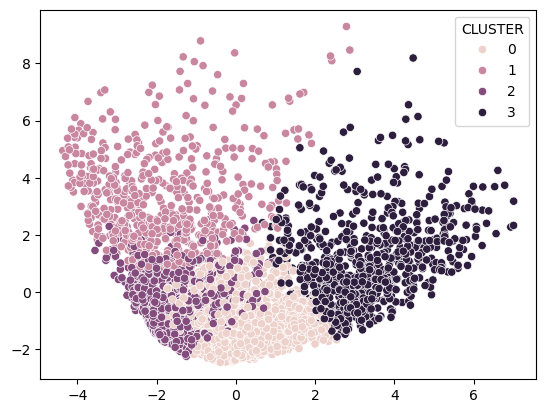

In [47]:
# cluster visualization in 2D
pca_2d = PCA(n_components=2) #to visualize in 2d
pca_2d.fit(df_scaled)

df_scaled_pca_2d = pca_2d.fit_transform(df_scaled)

sns.scatterplot(x=df_scaled_pca_2d[:,0], y=df_scaled_pca_2d[:,1], hue=df['CLUSTER'])

Dalam hal ini, kita menggunakan `n_components=2` dalam PCA untuk tujuan visualisasi agar perhitungan menjadi lebih cepat dan efisien. Hal ini dilakukan dengan mengurangi dimensi data ke dua dimensi utama yang paling mewakili variasi dalam data, dimana dua komponen utama ini berisikan informasi penting dari data asli yang cukup baik untuk memberikan gambaran tentang data tanpa kehilangan informasi yang signifikan.

## Exploratory Data Analysis after Clustering

Setelah mengelompokkan custemer, perlu dilakukan eksplorasi lebih lanjut terhadap setiap cluster yang terbentuk untuk mengidentifikasi karakteristik dari setiap clusternya.

### Pertama, saya ingin melihat distribusi masing-masing cluster yang telah terbentuk.

<Axes: xlabel='CLUSTER', ylabel='Count'>

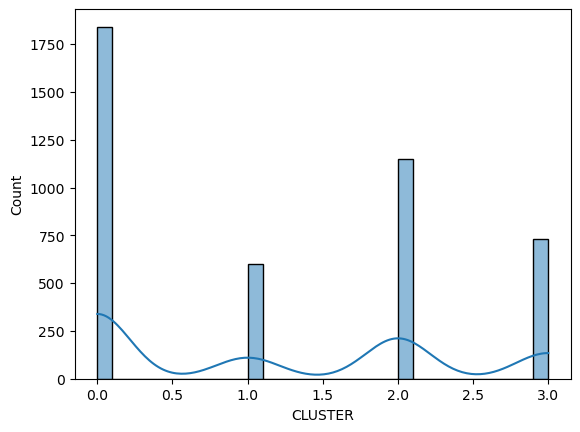

In [48]:
# data visualization
sns.histplot(df['CLUSTER'],kde=True,bins=30)

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 0 memiliki jumlah customer terbanyak, diikuti oleh cluster 2, 3, dan 1. Hal ini dapat menjadi panduan untuk menentukan strategi yang menjadi prioritas dikarenakan cluster dengan jumlah customer lebih banyak cenderung memberikan dampak yang lebih besar untuk perusahaan kartu kredit.

### Kedua, saya ingin melihat cluster mana yang paling sering melakukan pembelian dengan satu kali transaksi.

<Axes: xlabel='CLUSTER,ONEOFF_PURCHASES_FREQUENCY_CAT'>

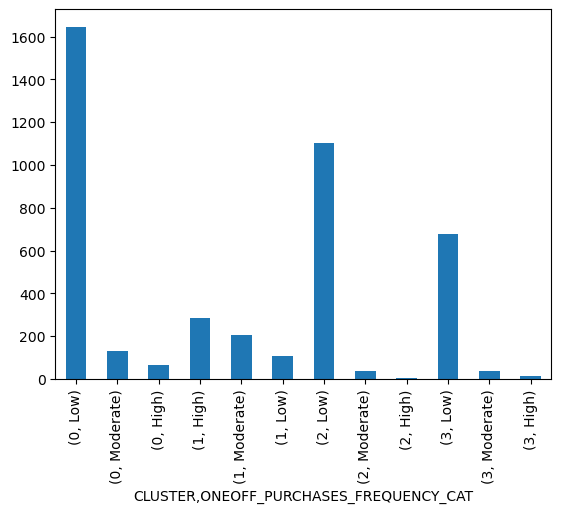

In [49]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.ONEOFF_PURCHASES_FREQUENCY:
    purchase_freq = float(i)
    if (purchase_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= purchase_freq < 0.8):
        lists.append('Moderate')
    elif (purchase_freq < 0.5):
        lists.append('Low')

# create new column
df['ONEOFF_PURCHASES_FREQUENCY_CAT'] = lists

# data visualization
df.groupby('CLUSTER')['ONEOFF_PURCHASES_FREQUENCY_CAT'].value_counts().plot(kind='bar')

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 0 memiliki jumlah frekuensi pembelian dengan satu kali transaksi yang sangat rendah. Hal ini mengindikasikan bahwa terdapat kemungkinan bahwa cluster 0 jarang melakukan transaksi menggunakan kartu kredit.

### Ketiga, saya ingin melihat cluster mana yang paling sering memilih untuk melakukan pembayaran dengan cicilan.

<Axes: xlabel='CLUSTER,PURCHASES_INSTALLMENTS_FREQUENCY_CAT'>

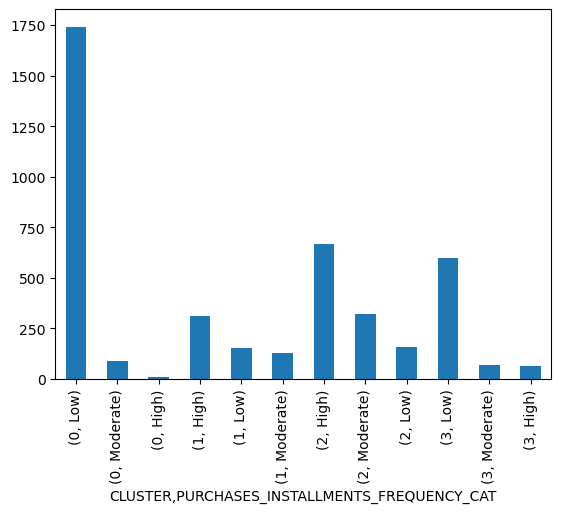

In [50]:
# create list to contain default value
lists = []

# create looping with for in
for i in df.PURCHASES_INSTALLMENTS_FREQUENCY:
    purchase_freq = float(i)
    if (purchase_freq >= 0.8):
        lists.append('High')
    elif (0.5 <= purchase_freq < 0.8):
        lists.append('Moderate')
    elif (purchase_freq < 0.5):
        lists.append('Low')

# create new column
df['PURCHASES_INSTALLMENTS_FREQUENCY_CAT'] = lists

# data visualization
df.groupby('CLUSTER')['PURCHASES_INSTALLMENTS_FREQUENCY_CAT'].value_counts().plot(kind='bar')

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 0 memiliki jumlah frekuensi pembelian dengan cicilan yang sangat rendah, sedangkan cluster 2 jumlah frekuensi pembelian dengan cicilan yang tinggi. Hal ini mengindikasikan bahwa kecenderungan behaviour cluster 0 adalah dapat menggunakan kartu kredit dengan bijak dan tidak berlebihan, sedangkan cluster 2 kecenderungan behaviournya adalah menggunakan kartu kredit untuk keperluan yang bersifat konsumtif.

### Keempat, saya ingin membandingkan cluster berdasarkan jumlah transaksi penarikan tunai menggunakan kartu kredit.

<Axes: xlabel='CLUSTER'>

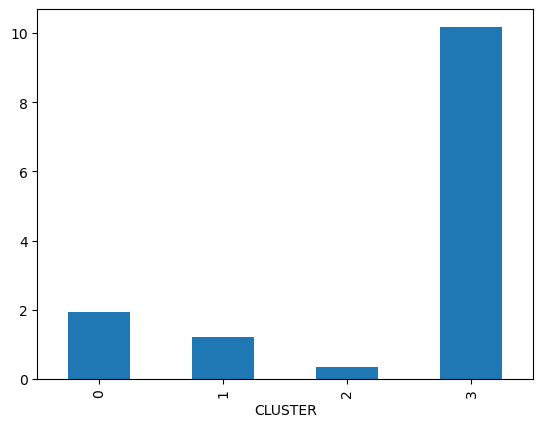

In [51]:
# data visualization
df.groupby('CLUSTER')['CASH_ADVANCE_TRX'].mean().plot(kind='bar')

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 3 paling sering melakukan transaksi penarikan tunai pada kartu kredit, dengan perbedaan yang sangat signifikan dengan cluster lainnya. Hal ini menandakan bahwa kemungkinan cluster 3 memiliki tanda-tanda masalah keuangan dikarenakan untuk melakukan penarikan tunai dengan kartu kredit biasanya dikenakan biaya tambahan.

### Kelima, saya ingin membandingkan cluster berdasarkan jumlah transaksi pembelian menggunakan kartu kredit.

<Axes: xlabel='CLUSTER'>

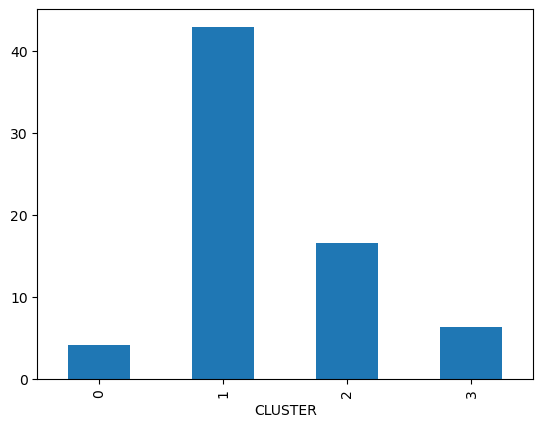

In [52]:
# data visualization
df.groupby('CLUSTER')['PURCHASES_TRX'].mean().plot(kind='bar')

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 1 memiliki jumlah transaksi pembelian terbanyak dibandingkan dengan cluster lainnya. Hal ini menandakan bahwa cluster 1 menjadi customer yang paling aktif menggunakan kartu kredit, baik untuk pengeluaran sehari-hari maupun konsumtif.

### Keenam, saya ingin mengelompokkan cluster berdasarkan limit kartu kreditnya.

<Axes: xlabel='CLUSTER'>

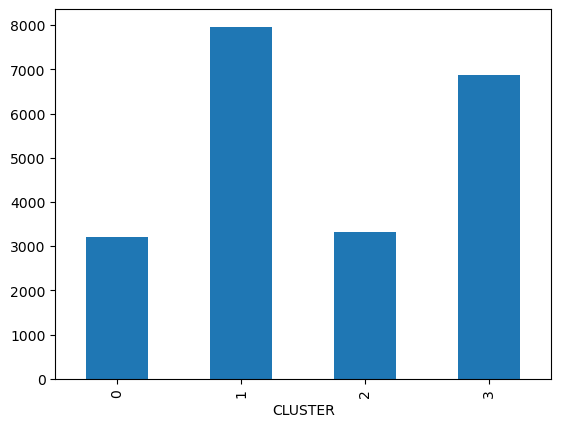

In [53]:
# data visualization
df.groupby('CLUSTER')['CREDIT_LIMIT'].mean().plot(kind='bar')

Berdasarkan gambar diatas, insight yang diperoleh adalah cluster 1 memiliki limit kartu kredit tertinggi, diikuti dengan cluster 3, 2, dan 0. Hal ini menandakan bawa semakin tinggi limit kartu kredit maka jumlah uang yang dipinjamkan lebih besar dan dapat melakukan pembelian dengan jumlah yang besar.
Berdasarkan insight ini, kita dapat mengkategorikan masing-masing cluster berdasarkan limit kartu kreditnya, yaitu cluster 1 termasuk kedalam kategori titanium dengan limit kartu kredit paling tinggi, diikuti oleh cluster 3 dengan katogori platinum, cluster 2 dengan kategori gold ,dan cluster 0 dengan kategori silver dengan limit kartu kredit paling rendah.

## Model Saving

In [54]:
# save files
with open('list_features.txt', 'w') as file_1:
  json.dump(features, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('model_pca.pkl', 'wb') as file_3:
  pickle.dump(pca, file_3)

with open('model_kmeans.pkl', 'wb') as file_4:
  pickle.dump(kmeans, file_4)

## Model Inference

Model inference adalah proses penerapan model mission learning yang telah dibuat untuk memprediksi data. File notebook untuk model inference dibuat terpisah pada notebook `inference_clustering.ipynb` karena pada notebook ini terdapat data bersifat rahasia yang berisikan data-data confidential.

## Conclusion

Berikut adalah insight dari exploratory data analysis:
- Frekuensi pembayaran kartu kredit oleh customer yang tinggi, dimana hal ini menandakan bahwa terdapat kecenderungan behaviour dimana customer secara rutin melakukan pembayaran tagihan kartu kreditnya.
- Frekuensi pembelian menggunakan kartu kredit oleh customer yang rendah, dimana hal ini menandakan bahwa terdapat kecenderungan behaviour dimana customer menggunakan kartu kredit dengan bijak dan tidak berlebihan, seperti hanya untuk keperluan mendesak atau sehari-hari saja dan tidak konsumtif.
- Frekuensi pembelian dengan satu kali transaksi menggunakan kartu kredit oleh customer yang rendah, dimana hal ini menandakan bahwa terdapat kecenderungan perilaku dimana customer jarang melakukan pengeluaran yang besar sekaligus dalam satu waktu dengan kemungkinan besar customer memilih menggunakan kartu kredit tidak berlebihan atau melakukan pembayaran dengan cicilan.
- Frekuensi pembelian dengan cicilan menggunakan kartu kredit oleh customer yang rendah. Artinya, kecenderungan behaviour customer kartu kredit adalah dapat menggunakan kartu kredit dengan bijak dan tidak berlebihan, terlebih untuk keperluan yang bersifat konsumtif, dimana hal ini mengindikasikan bahwa customer memiliki resiko kredit yang rendah dan sehat.
- Frekuensi penarikan tunai menggunakan kartu kredit oleh customer yang rendah, dimana hal ini menandakan bahwa mayoritas customer tidak memiliki tanda-tanda masalah keuangan dikarenakan untuk melakukan penarikan tunai dengan kartu kredit biasanya dikenakan biaya tambahan, dengan kemungkinan besar customer memilih untuk melakukan penarikan tunai dengan kartu debit atau melakukan pembayaran dengan cashless payment.
- Terdapat kecenderungan perilaku dimana customer hanya membayar sebagian kecil dari total tagihan kartu kreditnya setiap bulan saja sesuai minimum payment, dengan hanya sekitar 20% saja yang melakukan pembayaran penuh.
- Mayoritas customer kartu kredit memilih waktu tenor yang panjang, yaitu 12 bulan, dimana hal ini menunjukkan bahwa terdapat kecenderungan perilaku dimana customer memilih untuk membayar tagihan dengan cicilan yang lebih kecil setiap bulan secara teratur, meskipun bunga yang dibayarkan akan lebih besar dalam jangka panjang. Hal ini mengindikasikan bahwa pemilihan tenor cicilan ini kemungkinan dipilih untuk pembelian yang bersifat konsumtif, bukan untuk sehari-hari, dan hal ini juga menandakan customer dapat mengelola keuangan bulanan dengan baik sesuai dengan anggaran bulanan masing-masing customer.

Berdasarkan insight hasil exploratory data analysis, secara keseluruhan customer menggunakan kartu kredit secara terkendali dan dapat membayar kreditnya tepat wakti, dimana biasanya customer akan menggunakan kartu kredit hanya untuk pengeluaran/transaksi yang dibutuhkan secara rutin saja dengan pembayaran secara angsuran. Dengan kata lain, customer rata-rata memiliki resiko kredit yang rendah dan dapat membayar kredit tepat waktu.
Untuk itu, rekomendasi bisnisnya adalah membuat model machine learning dengan mengelompokkan customer berdasarkan behaviour/perilaku customer kedalam kelompok-kelompok yang berbeda sesuai dengan kecenderungan karakteristiknya, dimana hal ini akan berguna untuk melihat resiko kredit tiap customer dan menentukan pendekatan strategi marketing yang sesuai dengan karakteristik masing-masing kelompok.

Pembuatan machine learning akan menggunakan metode K-Means dengan mengelompokkan data berdasarkan pola karakteristik penggunaan kartu kreditnya. Untuk itu, akan dilakukan dimensionality reduction dengan PCA untuk membantu menentukan feature yang paling relevan dengan tetap mempertahankan informasi penting, dan Elbow Method untuk memilih jumlah cluster optimal. Selanjutnya, penentuan jumlah cluster akan dilakukan dengan membandingkan hasil Silhouette Score dan Silhouette Plot untuk menentukan jumlah cluster optimal.

Kelebihan menggunakan K-Means untuk clustering adalah cocok digunakan untuk tipe data numerical, dan kekurangannya adalah sensitif terhadap outlier sehingga harus membuat distribusi datanya normal terlebih dahulu. Improvement yang dapat dilakukan dari model yang dibuat adalah dengan melakukan trial and error pada tahap feature selection dan jumlah feature optimal pada tahap elbow method agar mendapatkan hasil Silhouette Score dan Silhouette Plot yang lebih baik sehingga pengelompokan data lebih akurat.

Dari hasil evaluasi K-Means, jumlah cluster yang optimal adalah 4. Berikut adalah exploratory data analisis berdasarkan pengelompokan yang telah dilakukan:
- Cluster 0:
    - Memiliki jumlah customer terbanyak.
    - Jumlah frekuensi pembelian dengan satu kali transaksi yang sangat rendah.
    - Jumlah frekuensi pembelian dengan cicilan yang sangat rendah.
    - Jumlah transaksi penarikan tunai pada kartu kredit yang cenderung rendah.
    - Jumlah transaksi pembelian dengan kartu kredit yang sangat rendah.
    - Kategori kartu kredit silver.
- Cluster 1:
    - Memiliki jumlah customer tersedikit.
    - Jumlah frekuensi pembelian dengan satu kali transaksi yang cenderung tinggi.
    - Jumlah frekuensi pembelian dengan cicilan yang cenderung tinggi.
    - Jumlah transaksi penarikan tunai pada kartu kredit yang cenderung rendah.
    - Jumlah transaksi pembelian dengan kartu kredit yang sangat tinggi.
    - Kategori kartu kredit titanium.
- Cluster 2:
    - Memiliki jumlah customer yang relatif banyak.
    - Jumlah frekuensi pembelian dengan satu kali transaksi yang rendah.
    - Jumlah frekuensi pembelian dengan cicilan yang sangat tinggi.
    - Jumlah transaksi penarikan tunai pada kartu kredit yang sangat rendah.
    - Jumlah transaksi pembelian dengan kartu kredit yang sedang.
    - Kategori kartu kredit gold.
- Cluster 3:
    - Memiliki jumlah customer yang relatif sedikit.
    - Jumlah frekuensi pembelian dengan satu kali transaksi yang rendah.
    - Jumlah frekuensi pembelian dengan cicilan yang rendah.
    - Jumlah transaksi penarikan tunai pada kartu kredit yang sangat tinggi.
    - Jumlah transaksi pembelian dengan kartu kredit yang rendah.
    - Kategori kartu kredit platinum.

Berdasarkan analisis di atas, berikut rekomendasi untuk strategi promosi yang relevan berdasarkan segmentasi masing-masing cluster:
1. Menjadikan cluster 0 sebagai segmentasi prioritas karena jumlah customer yang lebih banyak, diikuti oleh cluster 2, 3, dan 1. Hal ini bertujuan agar dapat memberikan dampak yang signifikan untuk perusahaan kartu kredit.
2. Cluster 0 dikelompokkan sebagai customer yang tidak aktif menggunakan kartu kredit. Untuk itu, strategi promosi yang sesuai adalah fokus memberikan edukasi tentang manfaat menggunakan kartu kredit, dimana kemungkinan customer masih kurang memahami sepenuhnya manfaat kartu kredit atau takut akan biaya bunga kartu kredit yang tinggi. Hal ini bertujuan untuk dapat membantu mengubah persepsi customer tentang kartu kredit menjadi lebih positif.
3. Cluster 1 dikelompokkan sebagai customer yang aktif menggunakan kartu kredit dan dapat menggunakan kartu kredit dengan bijak. Untuk itu, strategi promosi yang sesuai adalah membuat program loyalty khusus yang menawarkan reward poin, cashback, dan promo khusus. Hal ini bertujuan untuk mendorong customer agar lebih sering menggunakan kartu kreditnya.
4. Cluster 2 dikelompokkan sebagai customer dengan kecenderungan menggunakan kartu kredit untuk keperluan yang bersifat konsumtif. Untuk itu, strategi promosi yang sesuai adalah
menawarkan cicilan tanpa bunga dan menawarkan diskon khusus untuk keperluan sehari-hari. Namun, perlu diperhatikan bahwa terdapat masalah keuangan yang kemungkinan akan timbul. Untuk itu, perlu ditunjau kembali limit kartu kredit customer pada cluster ini untuk mengurangi resiko penggunaan kartu kredit yang tidak terkendali.
5. Cluster 3 dikelompokkan sebagai customer yang sering melakukan penarikan tunai. Untuk itu, strategi promosi yang sesuai adalah memberikan edukasi tentang penggunaan kartu kredit yang lebih bijak dengan menjelaskan manfaat menggunakan kartu kredit untuk transaksi pembelian daripada penarikan tunai, seperti mendapatkan reward dan cashback. Hal ini bertujuan untuk membuat customer lebih sering melakukan transaksi pembelian karena cluster ini juga memiliki limit kartu kredit yang cukup tinggi.

## Conceptual Problems

1. Dalam konteks clustering, K-means adalah metode untuk mengelompokkan data berdasarkan pola karakteristiknya. Tujuan utama penggunaan K-Means dalam mengelompokkan data adalah untuk menempatkan setiap titik data ke dalam kelompok/cluster yang sesuai berdasarkan jaraknya ke centroid, yaitu titik pusat cluster tersebut. Contohnya dalam kasus penggunaan kartu kredit ini, K-means akan mengelompokkan customer berdasarkan behaviour/perilaku customer kedalam kelompok-kelompok yang berbeda sesuai dengan kecenderungan karakteristiknya, seperti preferensi dan kebiasaannya.
Inertia dalam K-means adalah ukuran yang digunakan untuk mengevaluasi seberapa dekat titik-titik data dalam sebuah kelompok/cluster. Semakin kecil nilai inertia, semakin baik performa K-means dalam mengelompokkan data menjadi kelompok-kelompok yang padat dan terpisah dengan baik. Dengan kata lain, inertia membantu mengukur seberapa baik cluster yang terbentuk mengelompokkan titik-titik data yang serupa.

2. Elbow Method adalah teknik evaluasi yang digunakan dalam K-means untuk menemukan jumlah kelompok/cluster yang terbaik dalam data. Tujuan dilakukannya Elbow Method adalah membantu menentukan jumlah kelompok/cluster yang optimal untuk membagi data sehingga masing-masing cluster dapat mencerminkan pola yang ada dalam data secara optimal. Dengan Elbow Method, kita bisa memilih jumlah cluster yang sesuai dalam K-means agar hasil analisisnya lebih mudah dimengerti dan lebih berguna.
Elbow Method dilakukan dengan cara membuat grafik yang menunjukkan berapa banyak kelompok/cluster yang kita coba bandingkan dengan nilai yang diukur, seperti seberapa padatnya kelompok (inertia) atau seberapa bervariasinya data dalam setiap kelompok. Pada grafik ini, kita mencari titik dimana grafik menunjukkan perubahan yang tajam secara tiba-tiba dari vertikal ke horizontal. Titik ini menunjukkan jumlah cluster yang optimal untuk digunakan dalam analisis data, dimana penambahan cluster di atasnya tidak memberikan peningkatan yang signifikan dalam kualitas kelompok yang terbentuk.
Kelebihan dari penggunaan Elbow Method adalah dapat memberikan visualisasi yang jelas tentang bagaimana jumlah cluster mempengaruhi kualitas model yang dihasilkan. Namun, Elbow Method terkadang tidak dapat secara akurat menentukan jumlah cluster yang benar-benar optimal karena bersifat subjektif.